# Polyglot Data Science with IPython & friends

Author: [Fernando Pérez](http://fperez.org).

A demonstration of how to use Python, Julia, Fortran and R cooperatively to analyze data, in the same process.  

This is supported by the IPython kernel and a few extensions that take advantage of IPython's magic system to provide low-level integration between Python and other languages.

See the [companion notebook](polyglot-ds-prep.ipynb) for data preparation and setup.

Used for a lecture at the [Berkeley Institute for Data Science](https://bids.berkeley.edu). The [lecture video](https://youtu.be/ZwNCUetnccw) has a live demo of this material.

License: [CC-BY](https://creativecommons.org/licenses/by/4.0/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_context("talk", font_scale=1.4)

Let's begin by reading our dataset and having a quick look:

In [3]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head(3)

(300, 2)


,x,y
0,0.000000,0.094287
1,0.021014,-0.216828
2,0.042028,0.329982


Ah, it looks like we have a quantitative dataset with $(x,y)$ pairs - a scatterplot is a decent starting point to get a feel for these data:

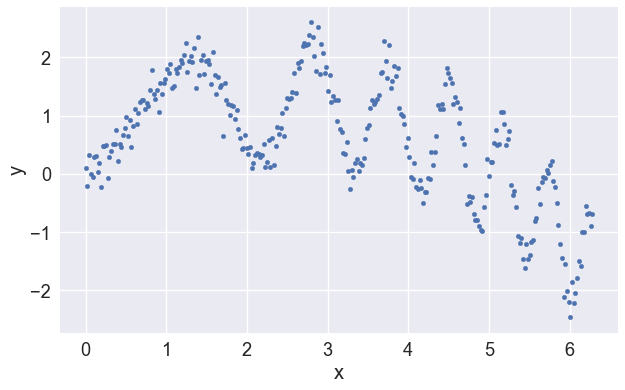

In [4]:
data.plot.scatter(x='x', y='y');

Mmh, what to do?

Let's try to build a simple linear model for these data, with some features we'll extract from the data. There's probably:

* a linear dependence
* something that looks broadly non-linear, let's say quadratic, to keep things simple
* and maybe an oscillatorty term: but it looks a bit like a chirp, not a simple sinusoid. Again, simplest non-linear choice: quadratic frequency dependency.

In summary, let's try

$$
y \sim \theta_1 x + \theta_2 x^2 + \theta_3 \sin(x^2)
$$

## Oh boy! Complicated data, Julia to the rescue...

Maybe Julia can help us efficiently compute that nasty non-linear feature, $x^2$?

In [ ]:
%load_ext julia.magic

In [ ]:
jxsq = %julia xsq(x) = x.^2  # Simplest way to define a function in Julia

We've defined the function `xsq` in Julia, and in Python we have it available as `jxsq`, which we can call as a normal Python function:

In [ ]:
x = data['x']
f2 = jxsq(x)
x.shape == f2.shape  # simple sanity check

# More complicated features, we need performance... 
## Fortran can help us!

Let's use this oldie but goodie to assist in the task of estimating our next non-linear feature, $\sin(x^2)$:

In [8]:
%load_ext fortranmagic

/Users/fperez/.local/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [9]:
%%fortran
subroutine sinx2(x, y, n)
    real, intent(in), dimension(n) :: x
    real, intent(out), dimension(n) :: y
    !intent(hide) :: n
    y = sin(x**2)
end subroutine sinx2

Now, `sinx2` can be used as a plain Python function too:

In [10]:
f3 = sinx2(x)
f3.shape == x.shape  # same sanity check

True

# Statistical modeling? Maybe R can do that??

We now have our data `y` and our features $x$, $f_2 = x^2$ and $f_3 = \sin(x^2)$.  This is a classic linear modeling problem, and R is awesome at fitting those!

Let's put our features together in a nice design matrix and load up R:

In [11]:
A = np.column_stack([x, f2, f3])
A.shape

(300, 3)

In [12]:
%load_ext rpy2.ipython
y = data['y']

In R, this can be written as a linear model `lm(y ~ 0 + A)`.

Note that we'll ask for the fit coefficients `fitc` to keep moving forward:


Call:
lm(formula = y ~ 0 + A)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7186 -0.1182  0.0090  0.1275  0.5450 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
A1  1.000707   0.012517   79.95   <2e-16 ***
A2 -0.199631   0.002566  -77.81   <2e-16 ***
A3  1.015147   0.016646   60.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1958 on 297 degrees of freedom
Multiple R-squared:  0.9741,	Adjusted R-squared:  0.9739 
F-statistic:  3730 on 3 and 297 DF,  p-value: < 2.2e-16



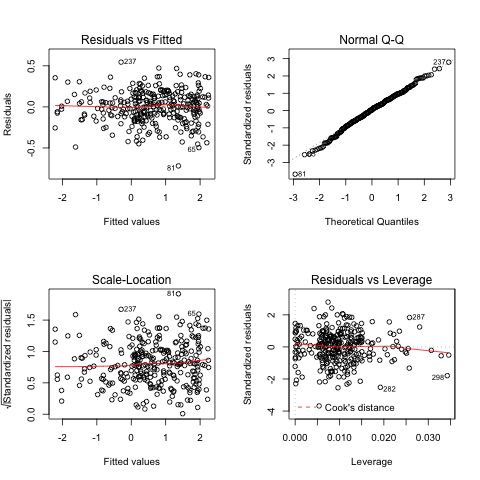

In [13]:
%%R -i y,A -o fitc

ylm = lm(y ~ 0 + A)
fitc = coef(ylm)
print(summary(ylm))
par(mfrow=c(2,2))
plot(ylm)

# Back to Python to look at the results!

R gave us our fit coefficient vector `fitc`, we can now proceed using it:

In [14]:
fitc

1.000707,-0.199631,1.015147


We construct our fitted model and visualize our results:

In [15]:
yfit = A @ fitc

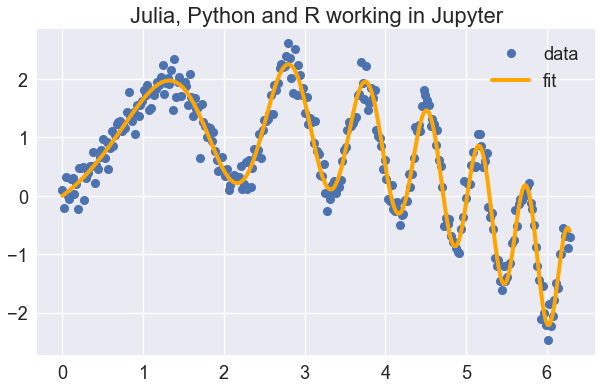

In [16]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, yfit, label='fit', color='orange', lw=4)
plt.title('Julia, Python and R working in Jupyter')
plt.legend();

# Polyglot Data Science FTW!!!

# Bonus

## Cython, the happy child of C and Python

In [17]:
def f(x):
    return x**2-x

def integrate_f(a, b, N):
    s = 0; dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [18]:
%load_ext Cython

In [19]:
%%cython -a
cdef double fcy(double x) except? -2:
    return x**2-x

def integrate_fcy(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s = 0; dx = (b-a)/N
    for i in range(N):
        s += fcy(a+i*dx)
    return s * dx

In [20]:
tpy = %timeit -o -n 1000 integrate_f(0, 1, 100)
tcy = %timeit -o -n 1000 integrate_fcy(0, 1, 100)

21.8 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
195 ns ± 0.482 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
tpy.best/tcy.best

100.78896158720855

## The Julia interoperability is pretty neat

In [22]:
%julia @pyimport numpy as np
%julia @pyimport matplotlib.pyplot as plt

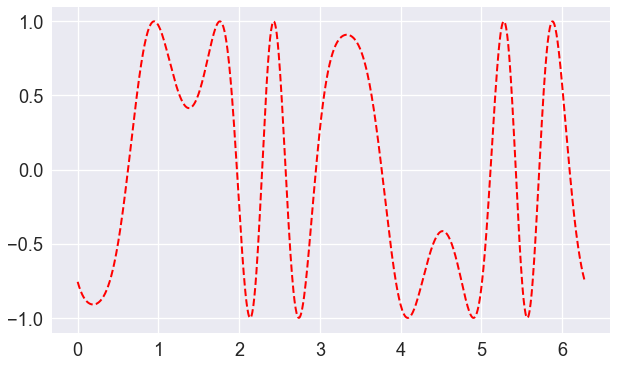

In [23]:
%%julia
# Note how we mix numpy and julia:
t = linspace(0,2*pi,1000); # use the julia linspace
s = sin(3*t + 4*np.cos(2*t)); # use the numpy cosine and julia sine
fig = plt.gcf()
plt.plot(t, s, color="red", linewidth=2.0, linestyle="--")

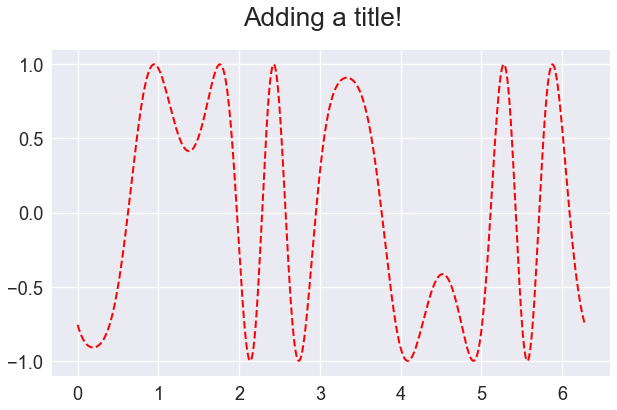

In [24]:
fig = %julia fig
fig.suptitle("Adding a title!")
fig

## And you can really use Fortran as an interactive language

In [25]:
%%fortran
subroutine f1(x, y, n)
    real, intent(in), dimension(n) :: x
    real, intent(out), dimension(n) :: y
    !intent(hide) :: n
    y = sin(x**2) - cos(x)
end subroutine f1

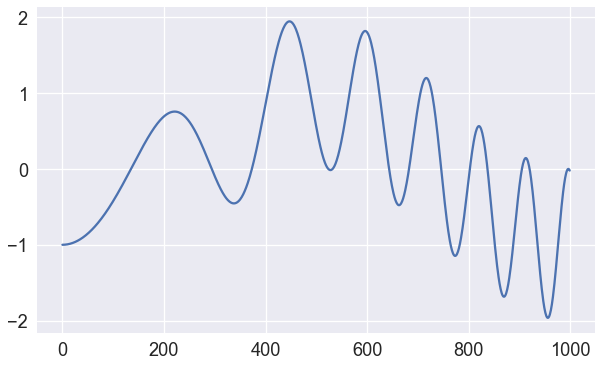

In [26]:
t = np.linspace(0,2* np.pi, 1000)
plt.plot(f1(t));

# Bash, Perl, Ruby, etc...

In [27]:
%%bash
echo $HOME

/Users/fperez


In [28]:
%%perl
@months = ("Jan", "Feb", "Mar");
print($months[1])

Feb